# ENVI Tutorial on Spatial Pancreas data

### Pre-requisites

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Change to -1 if you want to use CPU!

import warnings
warnings.filterwarnings('ignore')

In [2]:
import scenvi

2024-05-03 14:41:17.176135: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
#import colorcet
import sklearn.neighbors
import scipy.sparse
import umap.umap_ as umap
#from fa2 import ForceAtlas2

In [66]:
!pip install squidpy

  Using cached dask_image-2023.8.1-py2.py3-none-any.whl.metadata (23 kB)
  Using cached docrep-0.3.2.tar.gz (33 kB)
  Preparing metadata (setup.py) ... done
  Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached matplotlib_scalebar-0.8.1-py2.py3-none-any.whl.metadata (13 kB)
  Using cached omnipath-1.0.8-py3-none-any.whl.metadata (6.5 kB)
  Using cached spatialdata-0.1.2-py3-none-any.whl.metadata (9.3 kB)
  Using cached validators-0.28.1-py3-none-any.whl.metadata (3.6 kB)
  Using cached xarray-2024.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached zarr-2.17.2-py3-none-any.whl.metadata (5.7 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached partd-1.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached importlib_metadata-7.1.0-py3-none-any.whl.metadata (4.7 kB)
  Using cached PIMS-0.6.1.tar.gz (86 kB)
  Preparing metadata (se

### Data

In [12]:
adata_sc = sc.read('../../../../spatial_pancreas_data/preprocessed_data/dissociated_nd_annotation_l0.h5ad')
adata_s1 = sc.read('../../../../../../datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/S1.h5ad')

adata_sc, adata_s1

(AnnData object with n_obs × n_vars = 21453 × 23146
     obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse'
     var: 'n_cells'
     uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors'
     obsm: 'X_pca', 'X_scVI', 'X_umap'
     layers: 'counts', 'soupX_counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 108711 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK

### Subsetting and pre-processing

Subsampling to consider only Non-Diabetic slides (ND)

In [13]:
adata_sp = adata_s1[np.isin(adata_s1.obs['condition'],['ND'])].copy()
adata_sp

AnnData object with n_obs × n_vars = 61460 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [ ]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=5000,
    subset=True,
    layer='counts',
)
adata_sc

In [14]:
sc.pp.subsample(adata_sc,fraction=0.5)
adata_sc

AnnData object with n_obs × n_vars = 10726 × 23146
    obs: 'Sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'cell_type_coarse'
    var: 'n_cells'
    uns: 'Sample_colors', 'cell_type_coarse_colors', 'cell_type_coarse_sizes', 'dendrogram_cell_type_coarse', 'leiden', 'log1p', 'neighbors', 'paga', 'phase_colors'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts', 'soupX_counts'
    obsp: 'connectivities', 'distances'

Subset to a field of view to test the mapping problem 

In [15]:
adata_sp_fov_12 = adata_sp[np.isin(adata_sp.obs['fov'],['12'])].copy()
adata_sp_fov_12

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial'
    obsm: 'spatial', 'spatial_fov'
    layers: 'counts'

In [82]:
sc.pp.pca(adata_sp_fov_12)
sc.pp.neighbors(adata_sp_fov_12)
sc.tl.umap(adata_sp_fov_12)
sc.tl.leiden(adata_sp_fov_12)

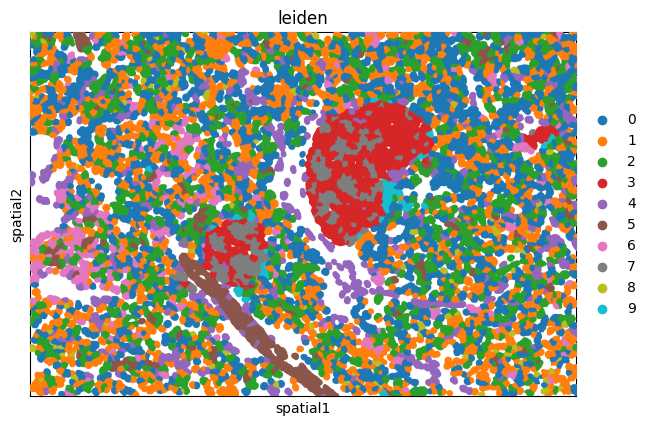

In [83]:
sq.pl.spatial_segment(adata_sp_fov_12,color='leiden',
                      library_key='fov', seg_cell_id='cell_ID', img=False)

### Running ENVI

ENVI requires un-logged counts and it doesn't work with adata.X sparse 

In [84]:
st_data = adata_sp_fov_12.copy()
st_data.X = st_data.layers['counts'].toarray()

sc_data = adata_sc.copy()
sc_data.X = adata_sc.layers['counts'].toarray()

print(sc_data.X.max())
print(st_data.X.max())

st_data, sc_data

8.0858965
177


(AnnData object with n_obs × n_vars = 5208 × 979
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'leiden'
     var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
     uns: 'log1p', 'spatial', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
     obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'distances', 'connectivities',
 Ann

In [85]:
# the gene names in the spatial data must be contained in the dissociated data 
st_data = st_data[:,np.isin(st_data.var_names, sc_data.var_names)].copy()
st_data

AnnData object with n_obs × n_vars = 5208 × 783
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'leiden'
    var: 'NegPrb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'spatial', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'spatial_fov', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [92]:
sc_data.obs['cell_type'] = sc_data.obs['cell_type_coarse']
st_data.obs['cell_type'] = st_data.obs['leiden']

In [93]:
envi_model = scenvi.ENVI(spatial_data = st_data, sc_data = sc_data)

Computing Niche Covariance Matrices
Initializing VAE
Finished Initializing ENVI


In [94]:
envi_model.train()
envi_model.impute_genes()
envi_model.infer_niche_covet()
envi_model.infer_niche_celltype(cell_type_key='leiden')

 spatial: -2.966e-01 sc: -1.851e-01 cov: -1.894e-03 kl: 5.171e-01: 100%|██████████| 16000/16000 [01:22<00:00, 193.02it/s]


Finished imputing missing gene for spatial data! See 'imputation' in obsm of ENVI.spatial_data


In [95]:
st_data.obsm['envi_latent'] = envi_model.spatial_data.obsm['envi_latent']
st_data.obsm['COVET'] = envi_model.spatial_data.obsm['COVET']
st_data.obsm['COVET_SQRT'] = envi_model.spatial_data.obsm['COVET_SQRT']
st_data.uns['COVET_genes'] =  envi_model.CovGenes
st_data.obsm['imputation'] = envi_model.spatial_data.obsm['imputation']
st_data.obsm['cell_type_niche'] = envi_model.spatial_data.obsm['cell_type_niche']

sc_data.obsm['envi_latent'] = envi_model.sc_data.obsm['envi_latent']
sc_data.obsm['COVET'] = envi_model.sc_data.obsm['COVET']
sc_data.obsm['COVET_SQRT'] = envi_model.sc_data.obsm['COVET_SQRT']
sc_data.obsm['cell_type_niche'] = envi_model.sc_data.obsm['cell_type_niche']
sc_data.uns['COVET_genes'] =  envi_model.CovGenes

In [35]:
len(st_data.uns['COVET_genes'])

68

In [36]:
len(sc_data.uns['COVET_genes'])

68

### ENVI imputation on Spatial Data 

In [96]:
markers = ['INS', 'GCG', 'SST', 'SOX9', 'KRT19', 'COL1A1', 'PECAM1', 'CD4']

In [97]:
import anndata as ann# Create the anndata object
adata_imputed = ann.AnnData(st_data.obsm['imputation'])
adata_imputed.uns['spatial'] = adata_sp_fov_12.uns['spatial']
adata_imputed.obsm['spatial'] = adata_sp_fov_12.obsm['spatial']
adata_imputed.obs['fov'] = adata_sp_fov_12.obs['fov']
adata_imputed.obs['cell_ID'] = adata_sp_fov_12.obs['cell_ID']  
adata_imputed

AnnData object with n_obs × n_vars = 5208 × 2583
    obs: 'fov', 'cell_ID'
    uns: 'spatial'
    obsm: 'spatial'

In [98]:
adata_imputed.var_names

Index(['AATK', 'ABL1', 'ABL2', 'ACE', 'ACE2', 'ACKR3', 'ACKR4', 'ACTA2',
       'ACVR1', 'ACVR1B',
       ...
       'ARID5B', 'DPYS', 'TTN', 'AC019068.1', 'LINC00607', 'PAQR8',
       'BX284613.2', 'CACNA1D', 'AC005224.2', 'TP63'],
      dtype='object', length=2583)

In [99]:
import squidpy as sq

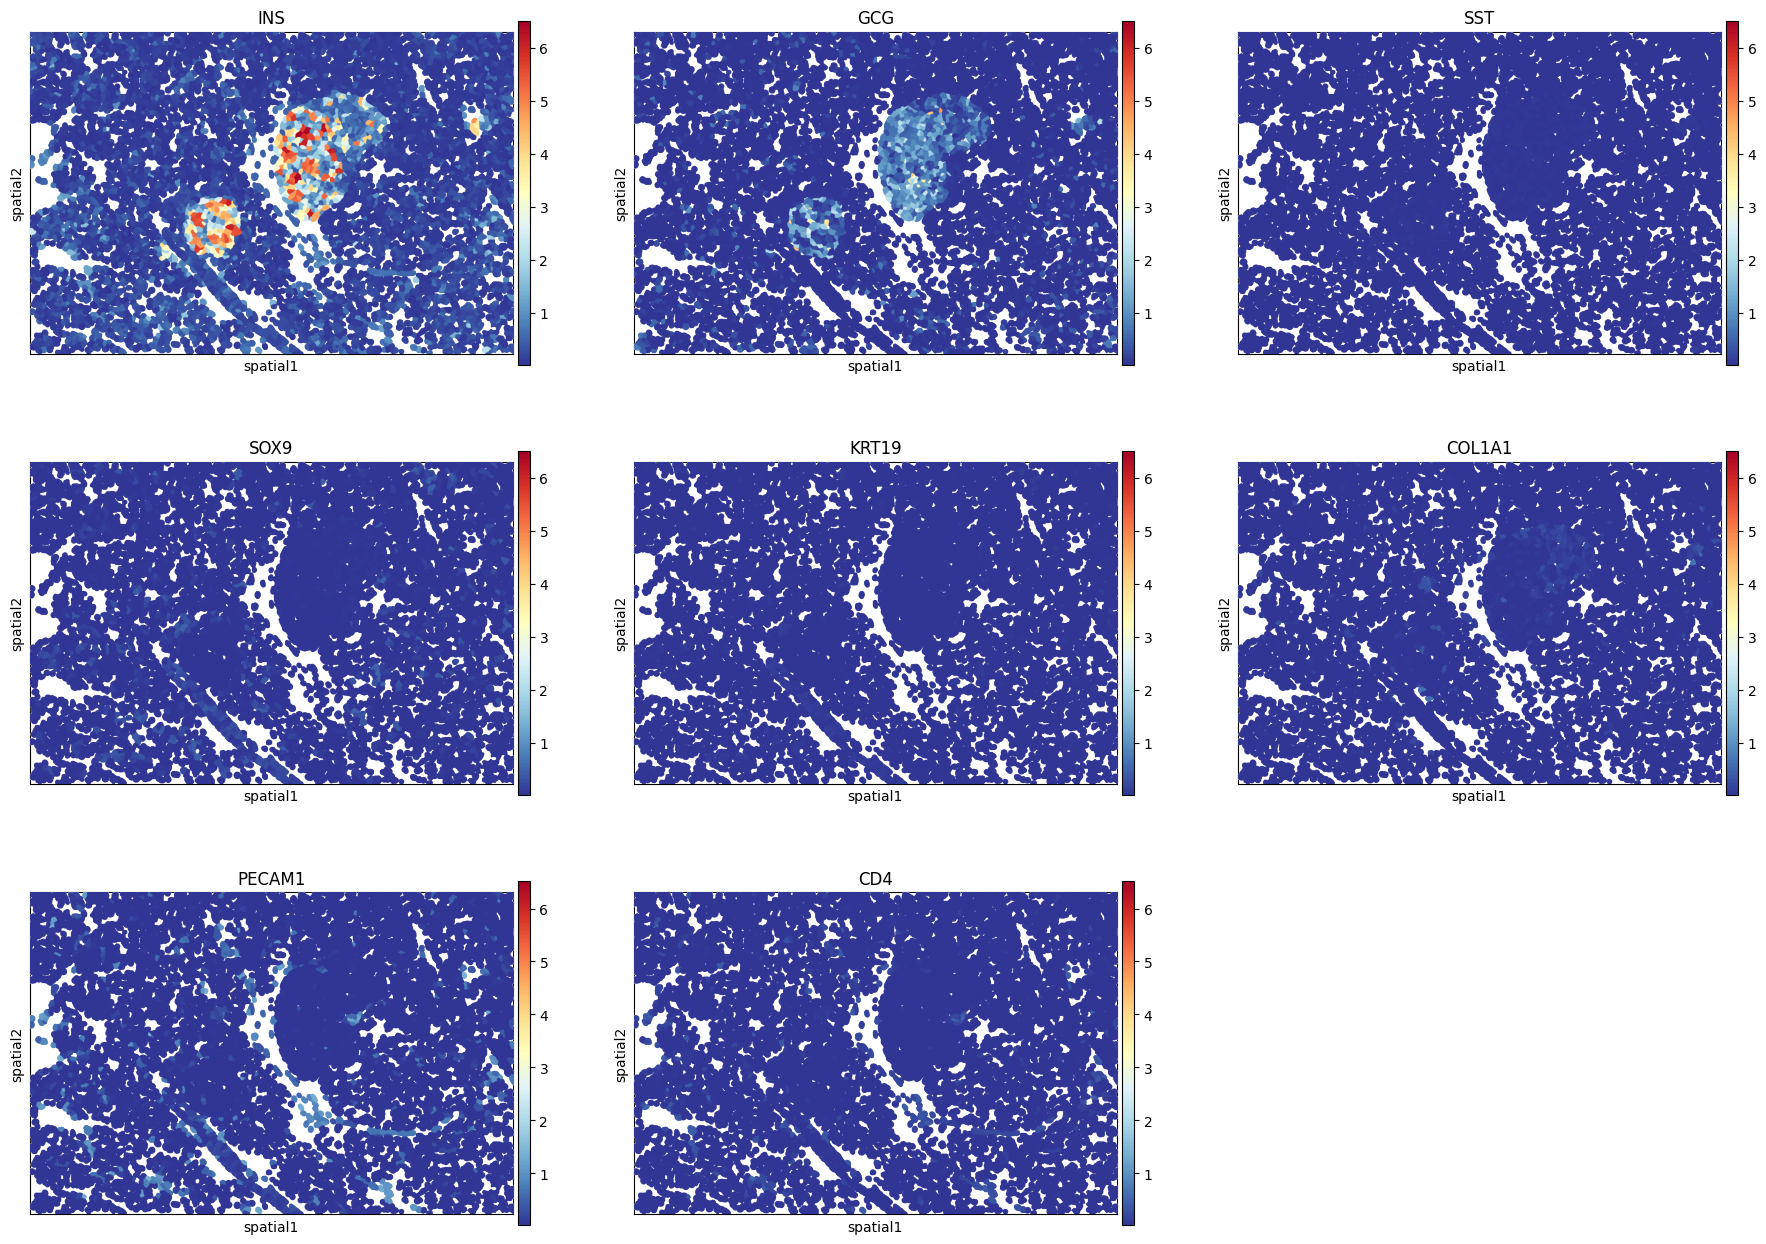

In [100]:
sq.pl.spatial_segment(adata_imputed,color=markers,ncols=3,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

In [101]:
from scipy.stats import pearsonr

correlations_hallmark_genes = []

for i in markers:
    gene = i
    obs_genes = adata_sp_fov_12[:,[gene]].X.copy().toarray().flatten()
    imp_genes = adata_imputed[:,[gene]].X.copy().flatten()
    correlation, p_value = pearsonr(obs_genes, imp_genes)
    row_data = {
        'gene' : gene,
        'Pearson_correlation' : correlation,
        'P_value' : p_value
    }
    correlations_hallmark_genes.append(row_data)
                
df = pd.DataFrame(correlations_hallmark_genes)

In [102]:
df

,gene,Pearson_correlation,P_value
0,INS,0.753141,0.000000e+00
1,GCG,0.675392,0.000000e+00
2,SST,0.225039,8.699773e-61
3,SOX9,0.354802,2.492814e-154
4,KRT19,0.320458,1.103107e-124
5,COL1A1,0.201748,5.779031e-49
6,PECAM1,0.133427,4.048328e-22
7,CD4,0.149423,2.184393e-27


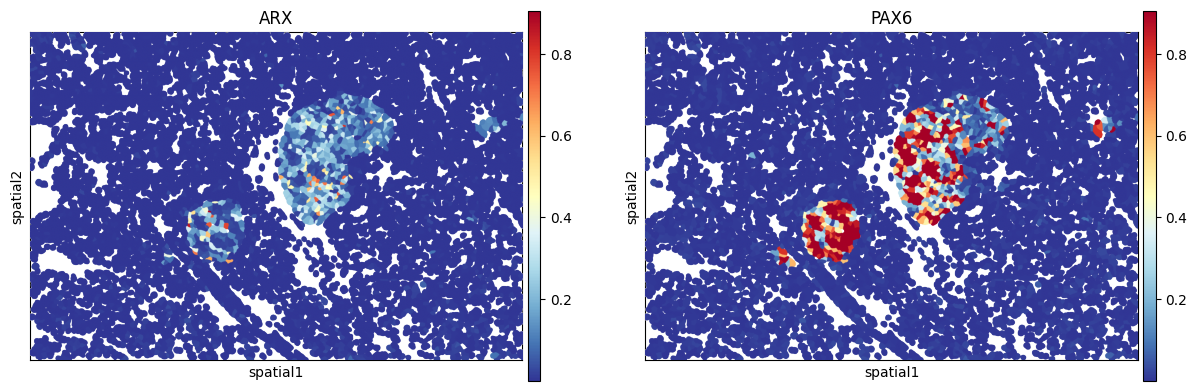

In [104]:
sq.pl.spatial_segment(adata_imputed,color=['ARX','PAX6'],ncols=2,
                      library_key='fov', seg_cell_id='cell_ID',cmap='RdYlBu_r', img=False)

### Plot UMAPs of ENVI latent

In [105]:
fit = umap.UMAP(
    n_neighbors = 100,
    min_dist = 0.3,
    n_components = 2,
)

latent_umap = fit.fit_transform(np.concatenate([st_data.obsm['envi_latent'], sc_data.obsm['envi_latent']], axis = 0))

st_data.obsm['latent_umap'] = latent_umap[:st_data.shape[0]]
sc_data.obsm['latent_umap'] = latent_umap[st_data.shape[0]:]

In [106]:

lim_arr = np.concatenate([st_data.obsm['latent_umap'], sc_data.obsm['latent_umap']], axis = 0)


delta = 1
pre = 0.1
xmin = np.percentile(lim_arr[:, 0], pre) - delta
xmax = np.percentile(lim_arr[:, 0], 100 - pre) + delta
ymin = np.percentile(lim_arr[:, 1], pre) - delta
ymax = np.percentile(lim_arr[:, 1], 100 - pre) + delta


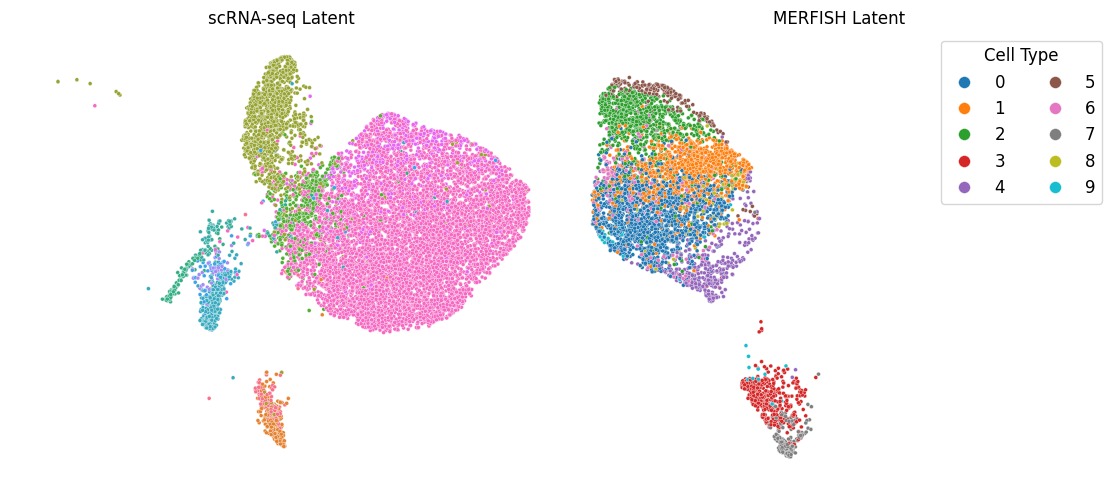

In [108]:
fig = plt.figure(figsize = (13,5))
plt.subplot(121)
sns.scatterplot(x = sc_data.obsm['latent_umap'][:, 0],
                y = sc_data.obsm['latent_umap'][:, 1], hue = sc_data.obs['cell_type'], s = 8, 
                legend = False)
plt.title("scRNA-seq Latent")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.axis('off')

plt.subplot(122)
sns.scatterplot(x = st_data.obsm['latent_umap'][:, 0],
                y = st_data.obsm['latent_umap'][:, 1],  hue = st_data.obs['cell_type'], s = 8,  legend = True)


legend = plt.legend(title = 'Cell Type', prop={'size': 12}, fontsize = '12',  markerscale = 3, ncol = 2, bbox_to_anchor = (1, 1))#, loc = 'lower left')
plt.setp(legend.get_title(),fontsize='12')
plt.title("MERFISH Latent")
plt.axis('off')
plt.tight_layout()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()